In [2]:
import sys
sys.path.append('..')

from src.visualization import plot_settings
from src.visualization import slides


data_path = '../data/raw'

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# disable user warnings
warnings.simplefilter("ignore", UserWarning)



In [59]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/raw/fullpilot5.csv')

# exclude participants  before 2024-02-22

# last batch
exp_mask = df.expName == 'FullPilot'
df = df[exp_mask]


# df = df[df.prolificID == 'basiletest']
# print shape[0] for each participant
df = df.groupby('prolificID').filter(lambda x: x.shape[0] >= 432)
df = df[df.prolificID.str.len() > 10]
print(df.groupby('prolificID').size())

df = df[df.session.isin([2, 3])]

df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['correct'] = (df.ev1 > df.ev2) & (df.choice == 1) | (df.ev2 > df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
df['trial'] = ((df.t.max()+1) * df.session) + df.t
print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)

print(pp)
    # break

prolificID
5c5ac2869d974300015d81fc    432
5cfb82a12bcca70018252f81    432
5dd4767b32288646716dc98a    432
63316daa57747115376760da    432
650ee274aa4447ac435b7830    432
dtype: int64
Number of participants: 5
[0.12 0.18 0.27 0.38 0.5  0.62 0.73 0.82 0.88]


In [5]:
# remove duplicated trials
df = df.drop_duplicates(subset=['prolificID', 'session', 't'])
df.groupby('prolificID').size()

prolificID
5c5ac2869d974300015d81fc    432
5cfb82a12bcca70018252f81    432
5dd4767b32288646716dc98a    432
63316daa57747115376760da    432
650ee274aa4447ac435b7830    432
dtype: int64

In [23]:
for pid in df.prolificID.unique():
    d = df[df.prolificID==pid]
    outcome = ((d.choice==1) * d.destroyed * d.outcome1) + ((d.choice==2) * d.outcome2 * d.destroyed)
    string = pid +','+ str(outcome.sum()*0.00029)
    print(d.correct.mean())
    print(string)


0.7476851851851852
5dd4767b32288646716dc98a,4.52632
0.8032407407407407
63316daa57747115376760da,4.68176
0.8078703703703703
5cfb82a12bcca70018252f81,4.81545
0.7314814814814815
650ee274aa4447ac435b7830,4.62695
0.7986111111111112
5c5ac2869d974300015d81fc,4.90593


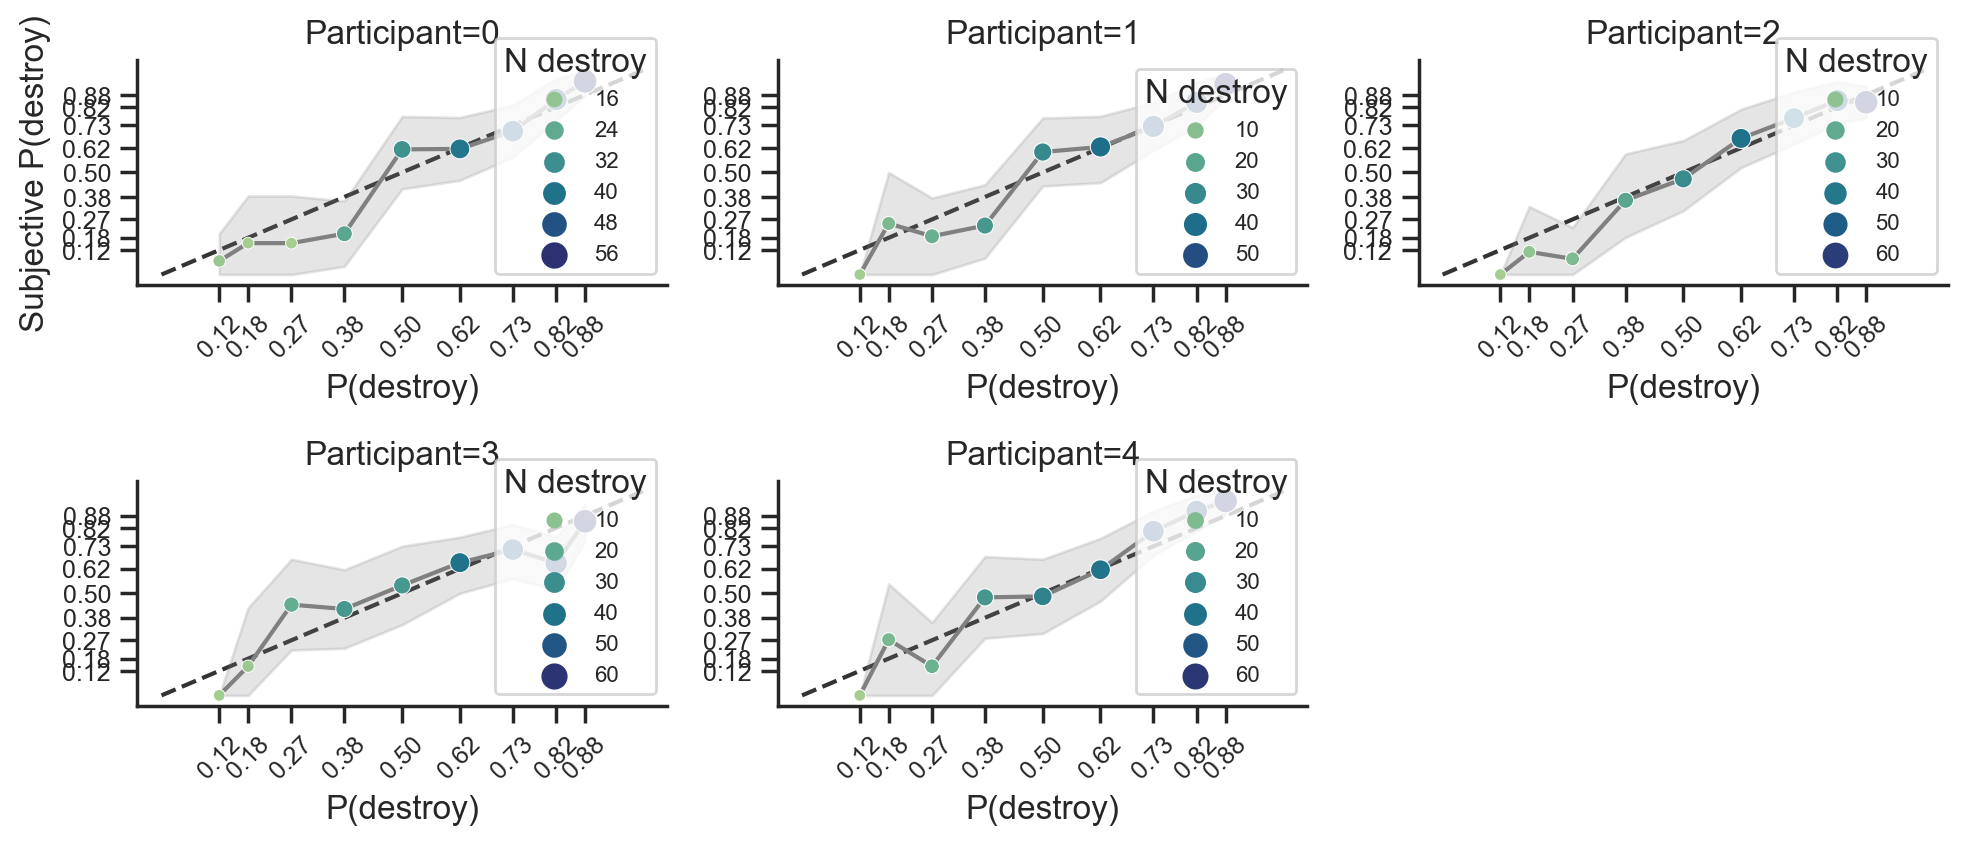

In [31]:
dd = []
for pid in df.id.unique():
    N = {}
    pobserved = {}
    for p in pp:
        ddf = df[(df.id == pid) & (df.session.isin([0, 1, 2, 3, 4, 5]))]
        pobserved[p] = ddf[((ddf.p1==p) & (ddf.choice==1)) | ((ddf.p2==p) & (ddf.choice==2))].destroyed.values
        N[p] = ddf[((ddf.p1==p) & (ddf.choice==1)) | ((ddf.p2==p) & (ddf.choice==2))].shape[0]
        for i in range(N[p]):
            dd.append(
                {
                 'pobserved': pobserved[p][i],   
                 'N': N[p],
                 'p': p,
                 'id': pid,
                }
            )

dd = pd.DataFrame(dd)
sns.set(rc={'figure.figsize':(10,8), 'figure.dpi': 200, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_style('ticks')

count = 0

for pid in dd.id.unique():

    count += 1
    
    ddd = dd[dd.id == pid]
    
    plt.subplot(4, 3, count)

    sns.lineplot(x='p', y='pobserved', color='grey', data=ddd, zorder=-1)
    sns.scatterplot(x='p', y='pobserved', size='N', hue='N',
                    data=ddd.filter(['p', 'pobserved', 'N'])
                    .groupby('p').mean().reset_index(), palette='crest')

    plt.ylabel('Subjective P(destroy)')
    plt.xlabel('P(destroy)')

    if count != 1:
        plt.ylabel('')

    plt.yticks(pp)
    plt.xticks(pp)
    plt.legend(title='N observed')
    # change legend size
    plt.legend(fontsize=8, title='N destroy', loc='lower right')

    plt.tick_params(axis='x', rotation=45)   
    
    plt.title(f'Participant={pid}')

    sns.despine()

    #plot identity line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', zorder=-10, alpha=0.8)

plt.tight_layout()

[0.12 0.18 0.27 0.38 0.5  0.62 0.73 0.82 0.88]


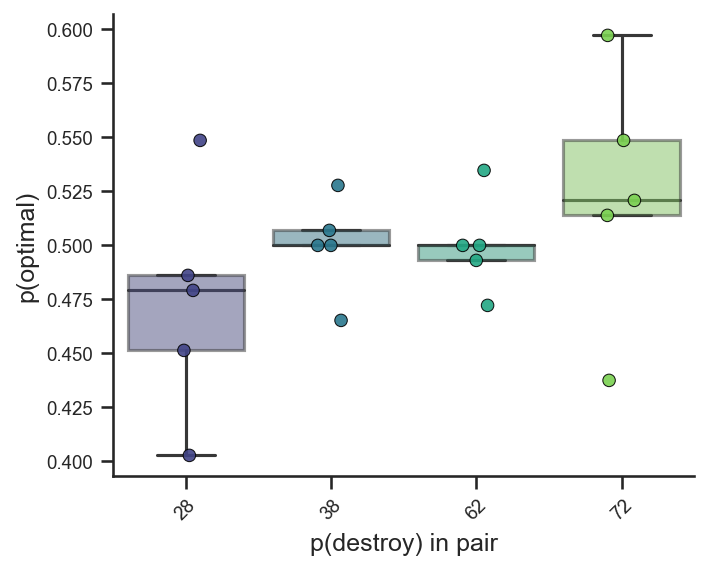

In [38]:
# plot y as choice frequency for each p
# plot x as p
# plot size as N (number of trials with p)
pp = np.unique(np.array([df.p1.unique(), df.p2.unique()]).flatten())
mm = np.unique(np.array([df.m1.unique(), df.m2.unique()]).flatten())
print(pp)
logit = lambda x: 1/(1+np.exp(-2*x))
assert sorted(pp) == logit(np.linspace(-1, 1, 9)).round(2).tolist()
p_freq = []
m_freq = []
for pid in df.id.unique():
    ddf = df[(df.id == pid)]
    for p1 in pp:
        n_p1 = ((ddf.p1 == p1) | (ddf.p2 == p1)).sum()
        p_freq.append(
            {
             'id': pid,
             'p': p1,
             'choice_freq_p': ((ddf.p1 == p1) & (ddf.choice == 1) | (ddf.p2 == p1) & (ddf.choice == 2)).sum() / n_p1,
             'N_p': n_p1,
             'correct_p': ((ddf.p1 == p1) & (ddf.choice == 1)  & (ddf.p1 > ddf.p2) | (ddf.p2 == p1) & (ddf.choice == 2) & (ddf.p2 > ddf.p1)).sum() / n_p1,
            }
        )
    
    for m in mm:
        n_m = ((ddf.m1 == m) | (ddf.m2 == m)).sum()
        m_freq.append(
            {
              'id': pid,
             'm': m,
             'choice_freq_m': ((ddf.m1 == m) & (ddf.choice == 1) | (ddf.m2 == m) & (ddf.choice == 2)).sum() / n_m,
             'N_m': n_m,
             'correct_m': ((ddf.m1 == m) & (ddf.choice == 1)  & (ddf.m1 > ddf.m2) | (ddf.m2 == m) & (ddf.choice == 2) & (ddf.m2 > ddf.m1)).sum() / n_m,
            }
        ) 

p_freq = pd.DataFrame(p_freq)
m_freq = pd.DataFrame(m_freq)

plt.figure(figsize=(5, 4), dpi=150)
sns.boxplot(x='m', y='choice_freq_m', data=m_freq, showfliers=False, boxprops=dict(alpha=0.5), zorder=-1, palette='viridis')   

sns.stripplot(x='m', y='choice_freq_m',data=m_freq, alpha=0.9, size=6, zorder=1, edgecolor='black', linewidth=0.5, palette='viridis')

# plot identity line
# plt.plot([0, len(pp)], [0, 1], color='black', linestyle='--', zorder=-10, alpha=0.8)
sns.despine()
plt.ylabel('p(optimal)')
plt.xlabel('p(destroy) in pair')
plt.tick_params(axis='x', rotation=45)
# slides.add('bw.pptx')
# plot text for N on top of bars
# for i in range(d_freq.N
    # plt.text(i, d_freq.choice_freq[i], d_freq.N[i], ha='center', va='bottom')
# pairs = set(map(tuple, (np.array([df.p1, df.p2]).T)))
# pairs = sorted(pairs, key=lambda x: abs(x[0] - x[1]))

# count = 0
# for p in pp:
#     # (a) plot text for N p appears in a pair
#     # (b) plot N for N p appears in a pair and is best response
#     # must be a/b
#     a = sum([p in pair for pair in pairs])
#     b = sum([(p in pair) and (p == max(pair)) for pair in pairs])
#     plt.text(count, 0.5, f'{b}/{a}', ha='center', va='bottom', fontsize=8)
#     count += 1

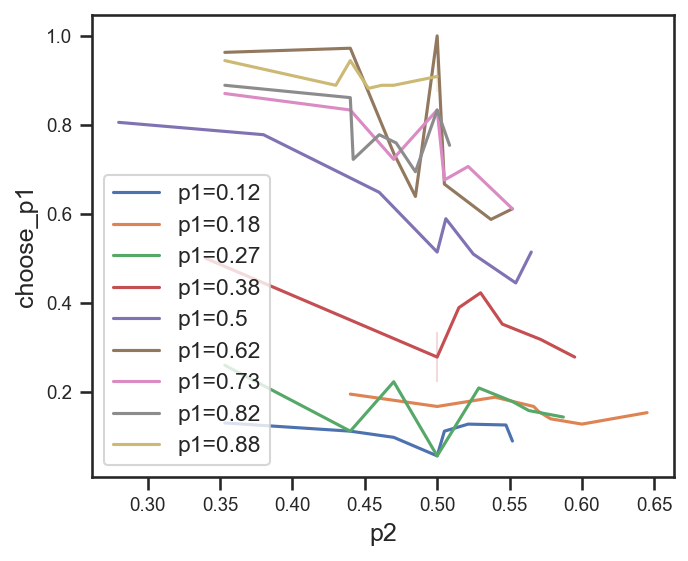

In [65]:
plt.figure(figsize=(5, 4), dpi=150)
# for each p plot the p(choose) against the other p as a lineplot
d = []
for p1 in df.p1.unique():
    for p2 in df.p2.unique():
        if p1 == p2:
            continue
        d.append(
            {
                'p1': p1,
                'p2': p2,
                'choose_p1': df[(df.p1 == p1) & (df.p2==p2) & (df.choice == 1)].shape[0] / df[(df.p1 == p1) & (df.p2==p2)].shape[0]
            }
        )

d = pd.DataFrame(d)

for p1 in sorted(df.p1.unique()):
    
    sns.lineplot(x='p2', y='choose_p1', data=d[d.p1 == p1].rolling(window=10, min_periods=1).mean(), label=f'p1={p1}',  ci=98)

# sns.boxplot(x='chosen_p', y='correct', data=df, showfliers=False, boxprops=dict(alpha=0.5), zorder=-1, palette='viridis')   

# sns.swarmplot(x='chosen_p', y='correct',data=df, alpha=0.9, size=3, zorder=1, edgecolor='black', linewidth=0.5, palette='viridis')

# # plot identity line
# plt.plot([0, len(pp)], [0, 1], color='black', linestyle='--', zorder=-10, alpha=0.8)
# sns.despine()
# plt.tick_params(axis='x', rotation=45)


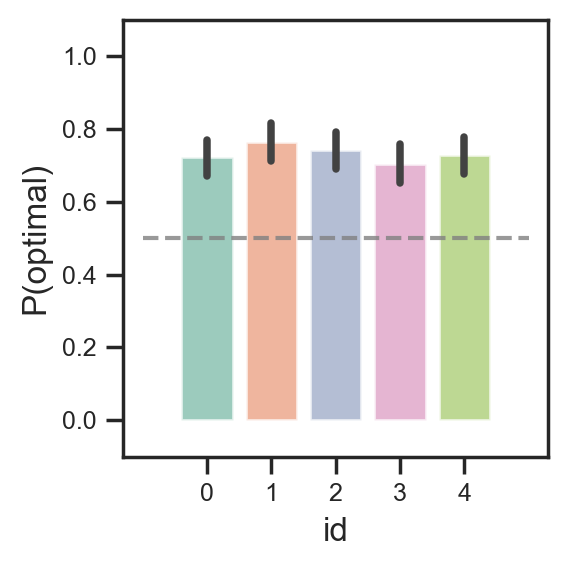

In [40]:
import seaborn as sns


sns.set(rc={'figure.figsize':(3,3), 'figure.dpi': 200, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_style('ticks')
sns.barplot(x='id', y='correct',  data=df, alpha=.7, palette='Set2')
plt.plot([-1, df.id.nunique()], [0.5, 0.5], color='grey', linestyle='--', zorder=10, alpha=0.8)
plt.ylabel('P(optimal)')
plt.ylim(-0.1, 1.1)

plt.tight_layout()
# slides.add('bw.pptx')

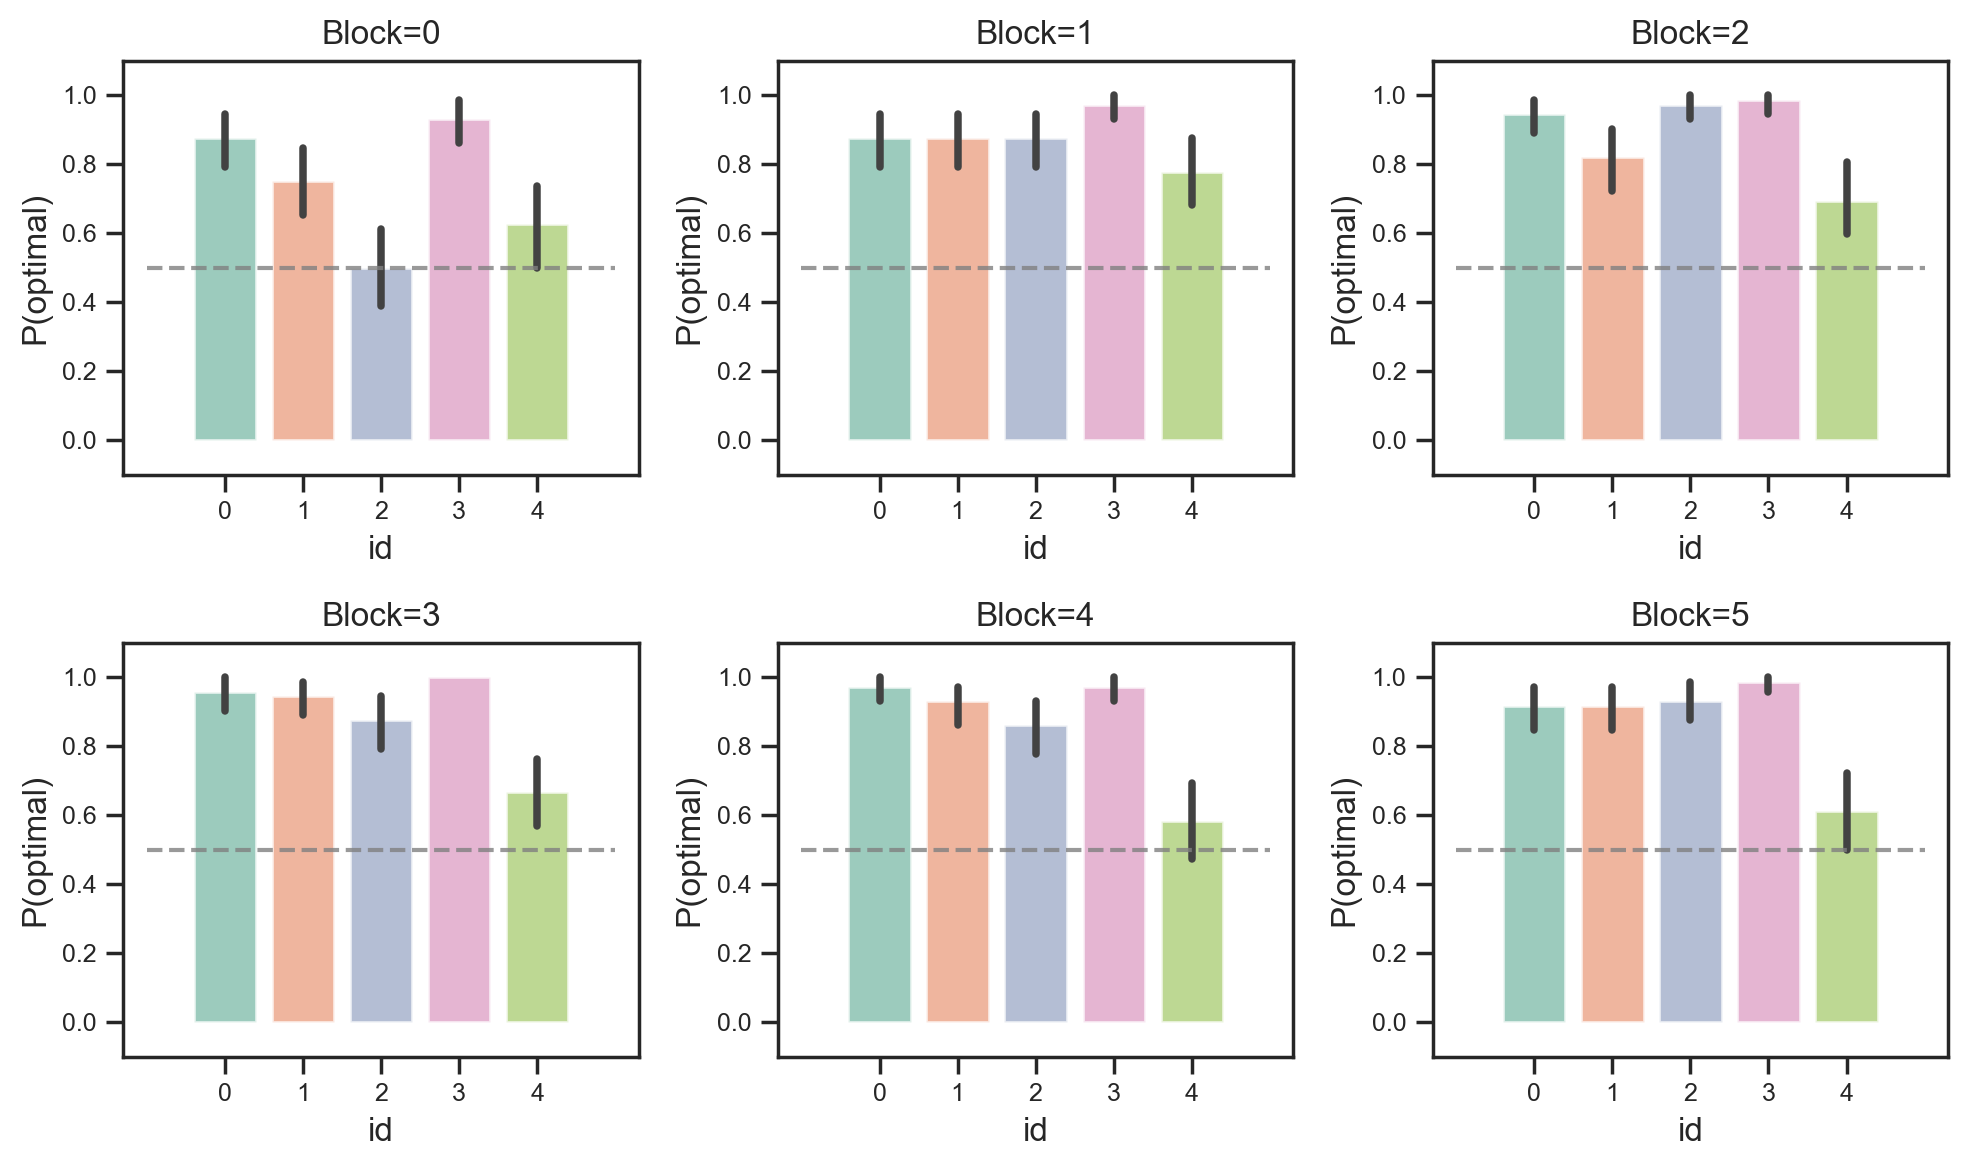

In [13]:
sns.set(rc={'figure.figsize':(10,6), 'figure.dpi': 200, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_style('ticks')

for session in df.session.unique():
    plt.subplot(2, 3, session+1)
    ddf = df[df.session == session]
    sns.barplot(x='id', y='correct', data=ddf, alpha=.7, palette='Set2')
    plt.plot([-1, ddf.id.nunique()], [0.5, 0.5], color='grey', linestyle='--', zorder=10, alpha=0.8)
    plt.ylabel('P(optimal)')
    plt.title(f'Block={session}')
    plt.ylim(-.1, 1.1)

plt.tight_layout()
# slides.add('bw.pptx')

In [36]:
# exclude bad participants
for pid in df.prolificID.unique():
    ddf = df[df.prolificID == pid]
    if ddf.correct.mean() < 0.55 and ddf.correct.mean() > 0.45:
        print(pid, ddf.correct.mean())

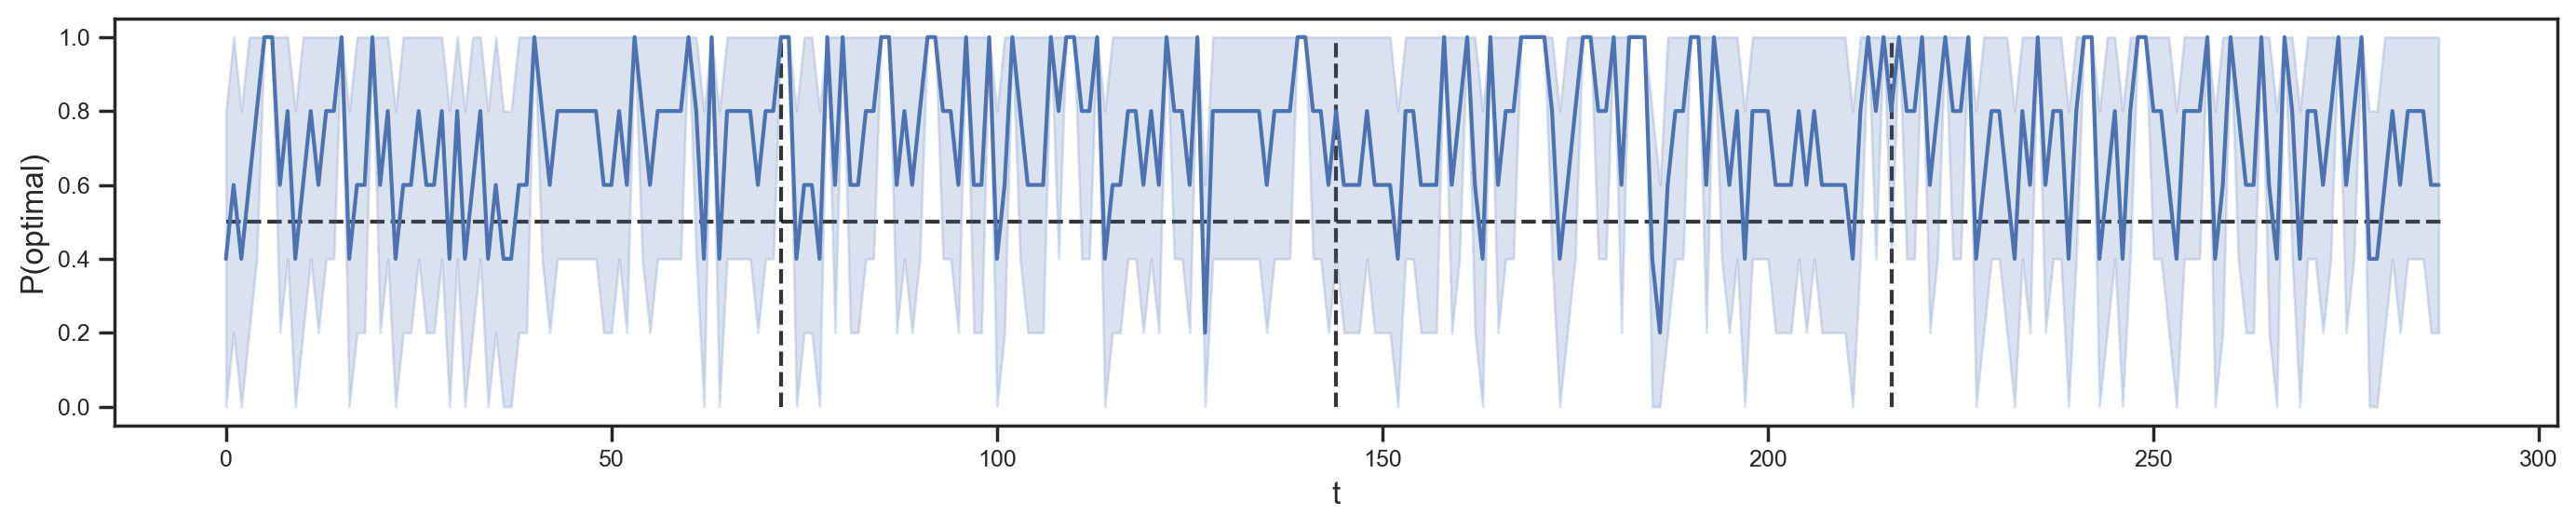

In [44]:
df2 = df.copy()
# df2['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
# there are 6 sessions with 64 trials per session
# we want to plot the learning curve for the 384 trials in total
df2['t'] = (df2.t.max()+1) * (df2.session-2) + df2.t
# check for each trial we have the correct session
""" assert df2[df2.session==0].t.isin(range(0, 64)).all()
assert df2[df2.session==1].t.isin(range(64, 128)).all()
assert df2[df2.session==2].t.isin(range(128, 192)).all()
assert df2[df2.session==3].t.isin(range(192, 256)).all()
assert df2[df2.session==4].t.isin(range(256, 320)).all()
assert df2[df2.session==5].t.isin(range(320, 384)).all()
 """
sns.set(rc={'figure.figsize':(14,3), 'figure.dpi': 200, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_style('ticks')
sns.lineplot(x='t', y='correct', data=df2)
plt.ylabel('P(optimal)')
plt.plot([0, 72*4], [0.5, 0.5], color='black', linestyle='--', zorder=-10, alpha=0.8)
# plt.xlim(0, )
# sns.scatterplot(x='p', y='correct', size='N', hue='N', data=df.groupby('p').mean().reset_index(), palette='crest')
# plot dootted line every 64 trials
for i in range(72, 72*4, 72):
    plt.plot([i, i], [0, 1], color='black', linestyle='--', zorder=-10, alpha=0.8)

plt.tight_layout()
slides.add('bw.pptx')

<Axes: xlabel='id', ylabel='correct'>

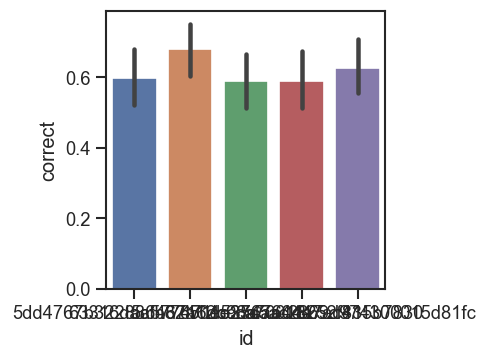

In [81]:
sim = []
for pid in df.prolificID.unique():
    ddf = df[(df.prolificID == pid) & (df.session.isin([2]))]
    
    for t in ddf.t:
        choice = 1 if (ddf[ddf.t == t].m1.values[0] > ddf[ddf.t == t].m2.values[0]) and (np.random.random() > .2) else 2
        dddf = ddf[ddf.t == t]
        sim.append(
            {
                't': t,
                'id': pid,
                'choice': choice,
                'correct': (choice == 1) & (dddf.ev1.values[0] > dddf.ev2.values[0]) | (choice == 2) & (dddf.ev2.values[0] > dddf.ev1.values[0]),
                'p1': dddf.p1.values[0],
                'p2': dddf.p2.values[0],
                'ev1':dddf.ev1.values[0],
                'ev2':dddf.ev2.values[0],
                'm1': dddf.m1.values[0],
                'm2': dddf.m2.values[0],
            }
        )

sim = pd.DataFrame(sim)

# sim
sns.barplot(x='id', y='correct', data=sim)

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     34.92
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.52e-07
Time:                        15:56:22   Log-Likelihood:                 11.096
No. Observations:                  55   AIC:                            -18.19
Df Residuals:                      53   BIC:                            -14.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5119      0.053      9.706      0.0

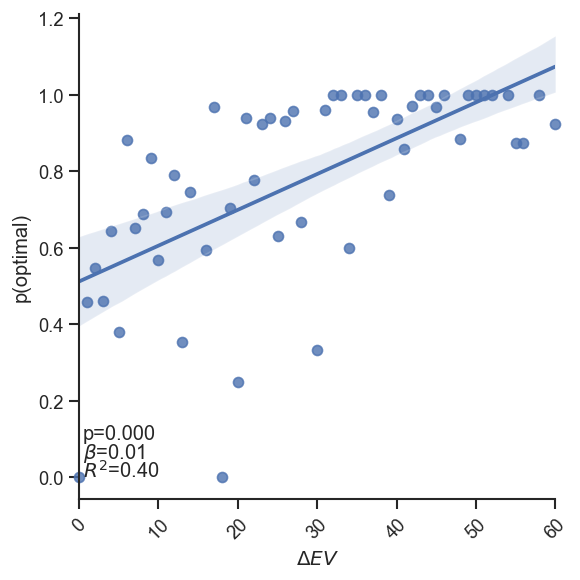

In [67]:
# df2 = df[df.session==0]
df2 = df.groupby(['delta_ev'], as_index=False).mean(numeric_only=True)
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(3,3), 'figure.dpi': 120})
sns.set_style('ticks')
sns.lmplot(x='delta_ev', y='correct', data=df2, palette='viridis', scatter=dict(zorder=1000), scatter_kws={'clip_on': False})
# plot R2
import statsmodels.formula.api as smf
plt.xlabel('$\\Delta EV$')
plt.ylabel('p(optimal)')
fit = smf.ols('correct ~ delta_ev', data=df2).fit()
beta = fit.params[1]
pvalue = fit.pvalues[1]
r = fit.rsquared
plt.xticks(rotation=45)
plt.text(0.5, df2.correct.min(), f'$R^2$={r:.2f}', fontsize=12)
plt.text(0.5, df2.correct.min()+.05, f'$\\beta$={beta:.2f}', fontsize=12)
plt.text(0.5, df2.correct.min()+.1, f'p={pvalue:.3f}', fontsize=12)
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
print(fit.summary())

plt.tight_layout()
slides.add('bw.pptx')

In [ ]:
df['correct'] = df['correct'].astype(int)
df2 = df.copy()
df2 = df2[df2.session.isin([0, 1, 2])]
smf.logit('correct ~ uncertainty', data=df2).fit().summary()

# sns.lmplot(x='uncertainty', y='correct',
# data=df, palette='viridis', scatter_kws={'clip_on': False}, logistic=True)

Optimization terminated successfully.
         Current function value: 0.325924
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 1920
Model:                          Logit   Df Residuals:                     1918
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                0.007849
Time:                        13:02:57   Log-Likelihood:                -625.77
converged:                       True   LL-Null:                       -630.73
Covariance Type:            nonrobust   LLR p-value:                  0.001651
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7448      0.154     11.332      0.000       1.443       2.047
uncertainty     1.2400      0.403      3.075      0.002       0.450       2.030
===============================================================================
"""

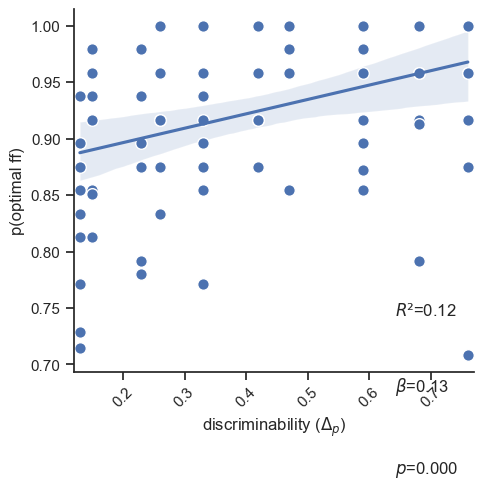

In [ ]:
# df2 = df[df.session==0]
def set_linear_info(r, beta, pvalue):
    """this function place text in the plot. 
    R^2, beta and p-value"""
    # get the current axis size
    x0, x1 = plt.xlim()
    y0, y1 = plt.ylim()
    # place the text in the top right corner
    plt.text(
        x1-x1/6, y1/1.2-y1/10, f'$R²$={r:.2f}', fontsize=12)
    plt.text(
        x1-x1/6, y1/1.2-y1/6, f'$\\beta$={beta:.2f}', fontsize=12)
    plt.text(
        x1-x1/6, y1/1.2-y1/4.2, f'$p$={pvalue:.3f}', fontsize=12)



df2 = df.copy()
# df2 = df2[df2.session.isin([0, 1, 2])]
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)

df2 = df2.filter(['prolificID', 'uncertainty', 'correct']).groupby(['prolificID', 'uncertainty'], as_index=False).mean()

sns.set(rc={'figure.figsize':(3,3), 'figure.dpi': 100})
sns.set_style('ticks')
sns.lmplot(x='uncertainty', y='correct', data=df2, palette='viridis', scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                                    'edgecolor': 'w',  's': 70})# plot R2
import statsmodels.formula.api as smf
plt.xlabel('discriminability ($\\Delta_p$)')
plt.ylabel('p(optimal ff)')
plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
fit = smf.ols('correct ~ uncertainty', data=df2).fit()
beta = fit.params[1]
pvalue = fit.pvalues[1]
r = fit.rsquared
plt.xticks(rotation=45)
set_linear_info(r, beta, pvalue)
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
fit.summary()
plt.tight_layout()
slides.add('test.pptx')

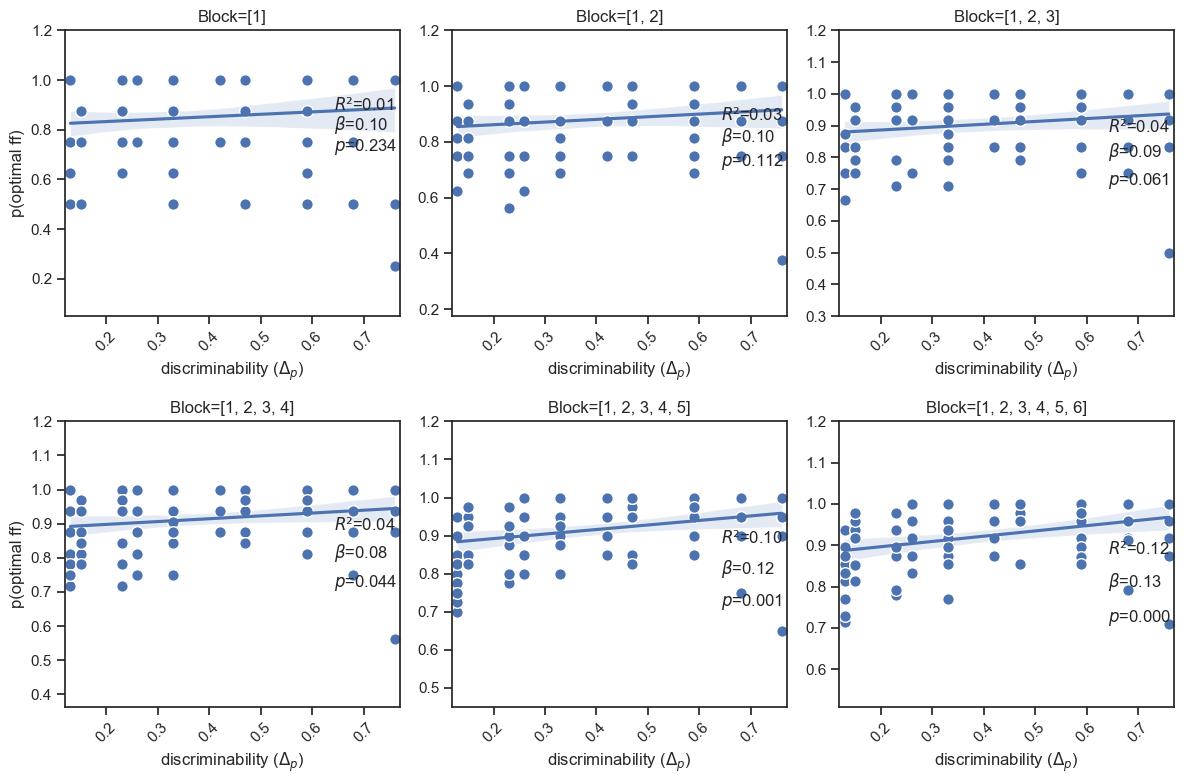

In [ ]:
# df2 = df[df.session==0]

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)


sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 100})
sns.set_style('ticks')
blocklist=[]
for block in range(6):
    ax = plt.subplot(2, 3, block+1)
    ax.clear()
    # blocklist = []
    blocklist.append(block)
    dff = df[df.session.isin(blocklist)] 
    dff = dff.filter(['prolificID', 'uncertainty', 'correct', 'session']).groupby(['uncertainty','prolificID'], as_index=False).mean()
    sns.regplot(ax=ax, x='uncertainty', y='correct', data=dff, scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                    'edgecolor': 'w', 's': 70})# plot R2
    plt.ylim(dff.correct.min()-.20, dff.correct.max()+.20)
    
    import statsmodels.formula.api as smf
    plt.ylabel('')
    if block in [0, 3]:
        plt.ylabel('p(optimal ff)')
    plt.xlabel('discriminability ($\\Delta_p$)')
    plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
    fit = smf.ols('correct ~ uncertainty', data=dff).fit()
    beta = fit.params[1]
    pvalue = fit.pvalues[1]
    r = fit.rsquared
    plt.xticks(rotation=45)
    set_linear_info(r, beta, pvalue)
    plt.title(f'Block={[i+1 for i in blocklist]}')
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
    fit.summary()

plt.tight_layout()
slides.add('test.pptx')

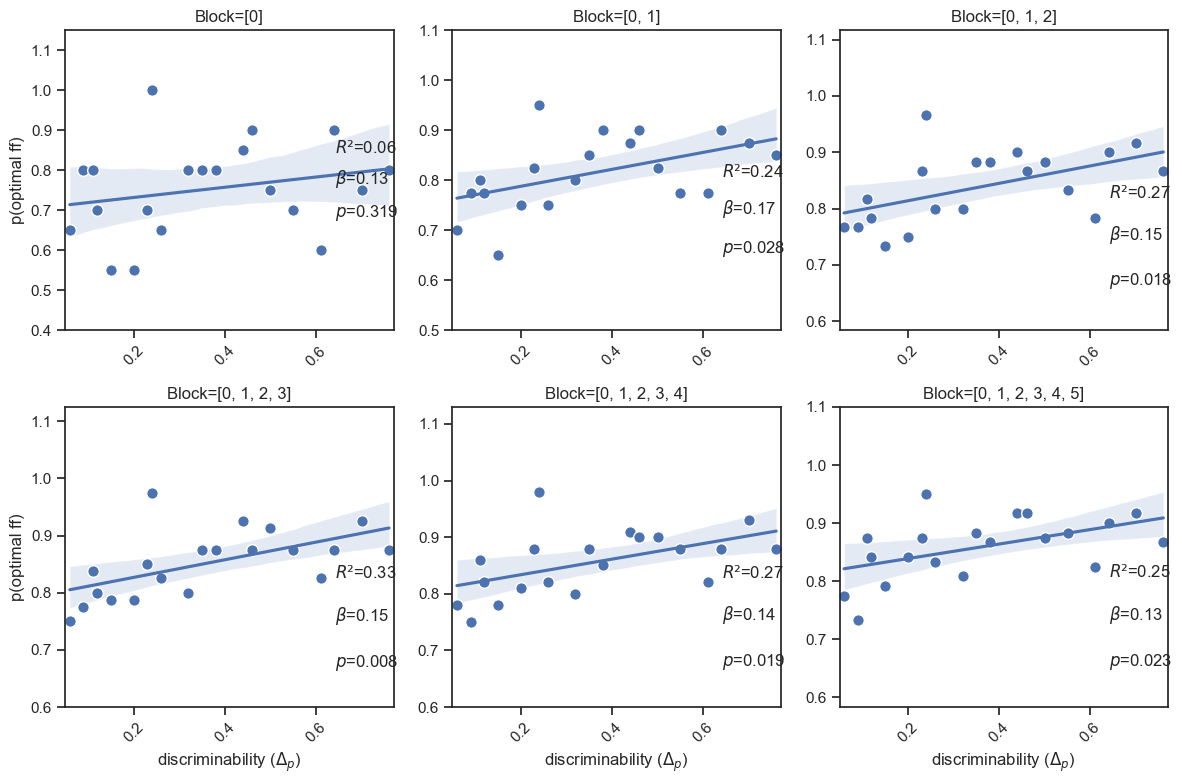

In [24]:
# df2 = df[df.session==0]
def set_linear_info(r, beta, pvalue):
    """this function place text in the plot. 
    R^2, beta and p-value"""
    # get the current axis size
    x0, x1 = plt.xlim()
    y0, y1 = plt.ylim()
    # place the text in the top right corner
    plt.text(
        x1-x1/6, y1/1.2-y1/10, f'$R²$={r:.2f}', fontsize=12)
    plt.text(
        x1-x1/6, y1/1.2-y1/6, f'$\\beta$={beta:.2f}', fontsize=12)
    plt.text(
        x1-x1/6, y1/1.2-y1/4.2, f'$p$={pvalue:.3f}', fontsize=12)

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)

df2 = df2.filter(['uncertainty', 'correct', 'session']).groupby(['uncertainty'], as_index=False).mean()

sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 100})
sns.set_style('ticks')
blocklist=[]
ax=[]
for block in range(6):
    blocklist.append(block)
    ax_ = plt.subplot(2, 3, block+1)
    ax.append(ax_)
    dff = df[df.session.isin(blocklist)] 
    dff = dff.filter(['uncertainty', 'correct', 'session']).groupby(['uncertainty'], as_index=False).mean()
    sns.regplot(ax=ax[block], x='uncertainty', y='correct', data=dff, scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                    'edgecolor': 'w', 's': 70})# plot R2
    plt.ylim(dff.correct.min()-.15, dff.correct.max()+.15)
    import statsmodels.formula.api as smf

    plt.ylabel('')
    if block in [0, 3]:
        plt.ylabel('p(optimal ff)')

    plt.xlabel('')
    if block in [3, 4, 5]:
        plt.xlabel('discriminability ($\\Delta_p$)')

    plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
    fit = smf.ols('correct ~ uncertainty', data=dff).fit()
    beta = fit.params[1]
    pvalue = fit.pvalues[1]
    r = fit.rsquared
    plt.xticks(rotation=45)

    set_linear_info(r, beta, pvalue)
    plt.title(f'Block={blocklist}')
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
    fit.summary()

plt.tight_layout()
slides.add('bw.pptx')

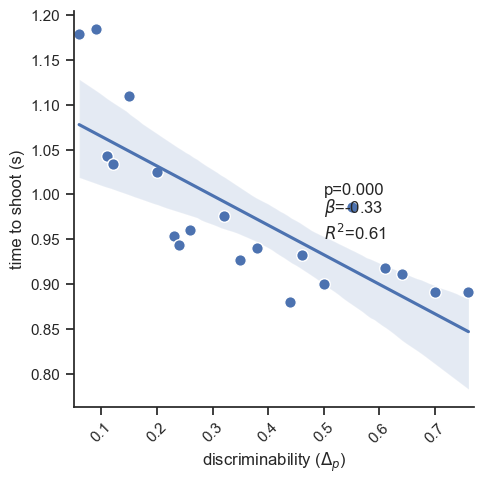

In [25]:
df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)

df2 = df2.filter(['uncertainty', 'fireTime']).groupby(['uncertainty'], as_index=False).mean()

sns.set(rc={'figure.figsize':(3,3), 'figure.dpi': 100})
sns.set_style('ticks')
sns.lmplot(x='uncertainty', y='fireTime', data=df2, palette='viridis', scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                                    'edgecolor': 'w', 's': 70})# plot R2
import statsmodels.formula.api as smf

plt.xlabel('discriminability ($\\Delta_p$)')
plt.ylabel('time to shoot (s)')
plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
fit = smf.ols('fireTime ~ uncertainty', data=df2).fit()
beta = fit.params[1]
pvalue = fit.pvalues[1]
r = fit.rsquared
plt.xticks(rotation=45)

plt.text(0.5, df2.fireTime.min()+.07, f'$R^2$={r:.2f}', fontsize=12)
plt.text(0.5, df2.fireTime.min()+.1, f'$\\beta$={beta:.2f}', fontsize=12)
plt.text(0.5, df2.fireTime.min()+.12, f'p={pvalue:.3f}', fontsize=12)
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
fit.summary()
slides.add('bw.pptx')

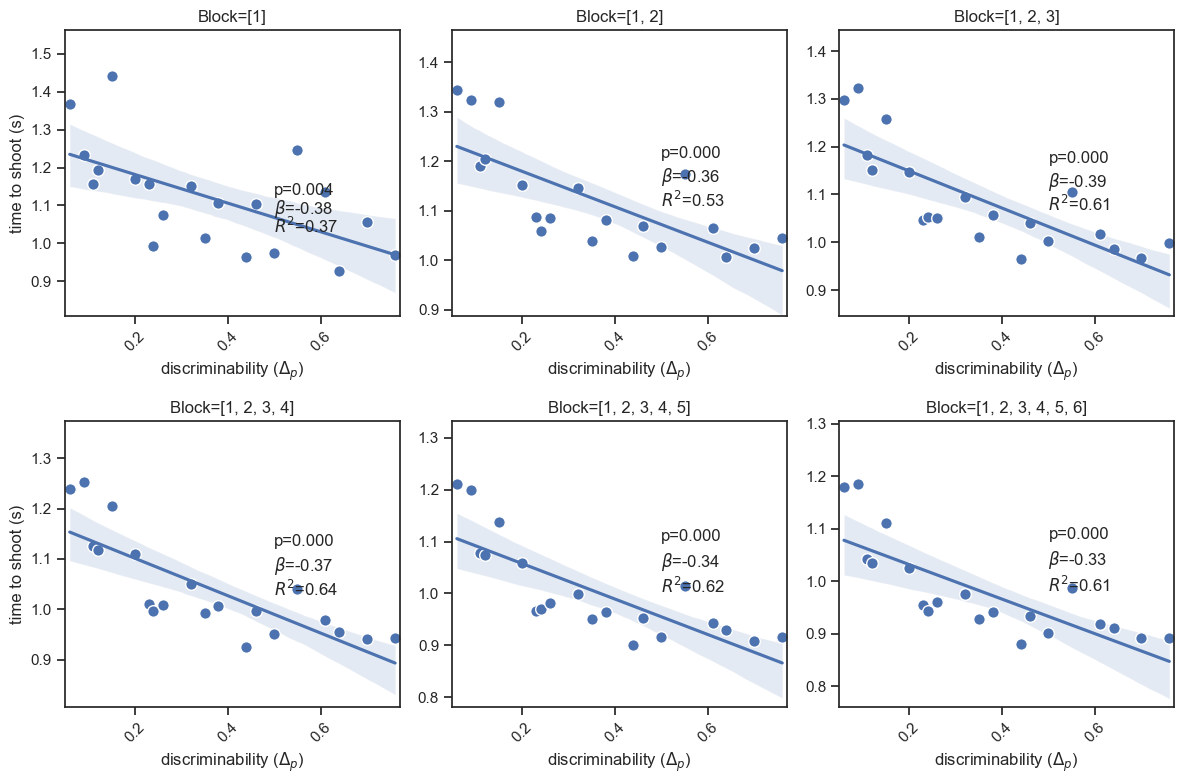

In [26]:
# df2 = df[df.session==0]

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)


sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 100})
sns.set_style('ticks')
blocklist=[]
for block in range(6):
    ax = plt.subplot(2, 3, block+1)
    ax.clear()
    # blocklist = []
    blocklist.append(block)
    dff = df[df.session.isin(blocklist)] 
    dff = dff.filter(['uncertainty', 'fireTime', 'session']).groupby(['uncertainty'], as_index=False).mean()
    sns.regplot(ax=ax, x='uncertainty', y='fireTime', data=dff, scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                    'edgecolor': 'w', 's': 70})# plot R2
    plt.ylim(dff.fireTime.min()-.12, dff.fireTime.max()+.12)
    
    import statsmodels.formula.api as smf
    plt.ylabel('')
    if block in [0, 3]:
        plt.ylabel('time to shoot (s)')
    plt.xlabel('discriminability ($\\Delta_p$)')
    plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
    fit = smf.ols('fireTime ~ uncertainty', data=dff).fit()
    beta = fit.params[1]
    pvalue = fit.pvalues[1]
    r = fit.rsquared
    plt.xticks(rotation=45)
    plt.text(0.5, dff.fireTime.min()+.1, f'$R^2$={r:.2f}', fontsize=12)
    plt.text(0.5, dff.fireTime.min()+.15, f'$\\beta$={beta:.2f}', fontsize=12)
    plt.text(0.5, dff.fireTime.min()+.2, f'p={pvalue:.3f}', fontsize=12)
    plt.title(f'Block={[i+1 for i in blocklist]}')
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
    fit.summary()

plt.tight_layout()
slides.add('bw.pptx')

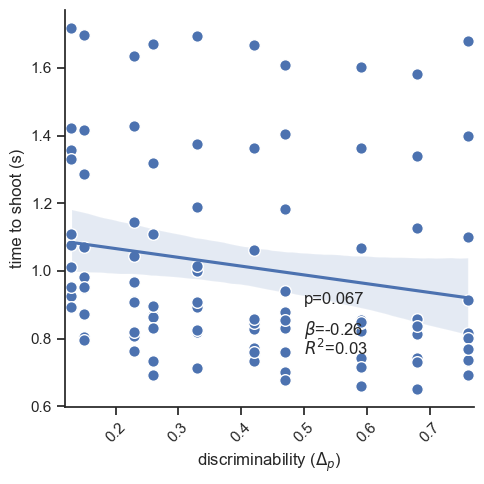

In [ ]:
# df2 = df[df.session==0]

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)

df2 = df2.filter(['uncertainty', 'fireTime', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()

sns.set(rc={'figure.figsize':(3,3), 'figure.dpi': 100})
sns.set_style('ticks')
sns.lmplot(x='uncertainty', y='fireTime', data=df2, palette='viridis', scatter_kws={'clip_on': False, 'zorder': 2, 'alpha': 1,
                                                                                    'edgecolor': 'w',  's': 70})# plot R2
import statsmodels.formula.api as smf
plt.xlabel('discriminability ($\\Delta_p$)')
plt.ylabel('time to shoot (s)')
plt.xlim(min(df2.uncertainty)-0.01, max(df2.uncertainty)+.01)
fit = smf.ols('fireTime ~ uncertainty', data=df2).fit()
beta = fit.params[1]
pvalue = fit.pvalues[1]
r = fit.rsquared
plt.xticks(rotation=45)

plt.text(0.5, df2.fireTime.min()+.1, f'$R^2$={r:.2f}', fontsize=12)
plt.text(0.5, df2.fireTime.min()+.16, f'$\\beta$={beta:.2f}', fontsize=12)
plt.text(0.5, df2.fireTime.min()+.25, f'p={pvalue:.3f}', fontsize=12)
# plt.xticks(df2.uncertainty.unique())
# sns.despine(trim=True)
# plt.ylim(-0.1, 1.1)
# print(means)
fit.summary()

plt.tight_layout()
slides.add('test.pptx')

Text(0, 0.5, 'p(optimal ff)')

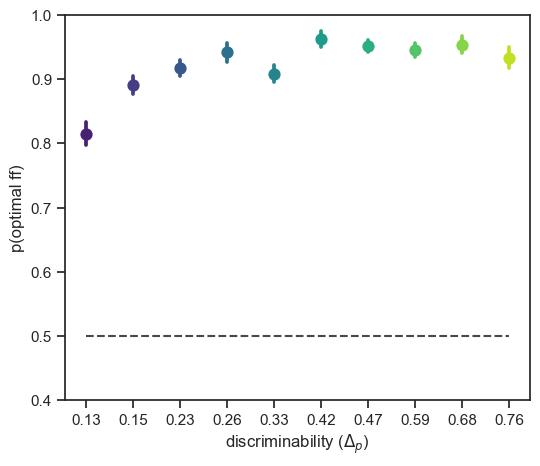

In [ ]:

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(6,5), 'figure.dpi': 100})
sns.set_style('ticks')
ax = sns.pointplot(x='uncertainty', y='correct', data=df, palette='viridis', errorbar='se', zorder=-1)
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
plt.plot([0, 9], [0.5, 0.5], color='k', linestyle='--', zorder=-10, alpha=0.8)
plt.ylim(0.4,1)
plt.xlabel('discriminability ($\\Delta_p$)')
plt.ylabel('p(optimal ff)')

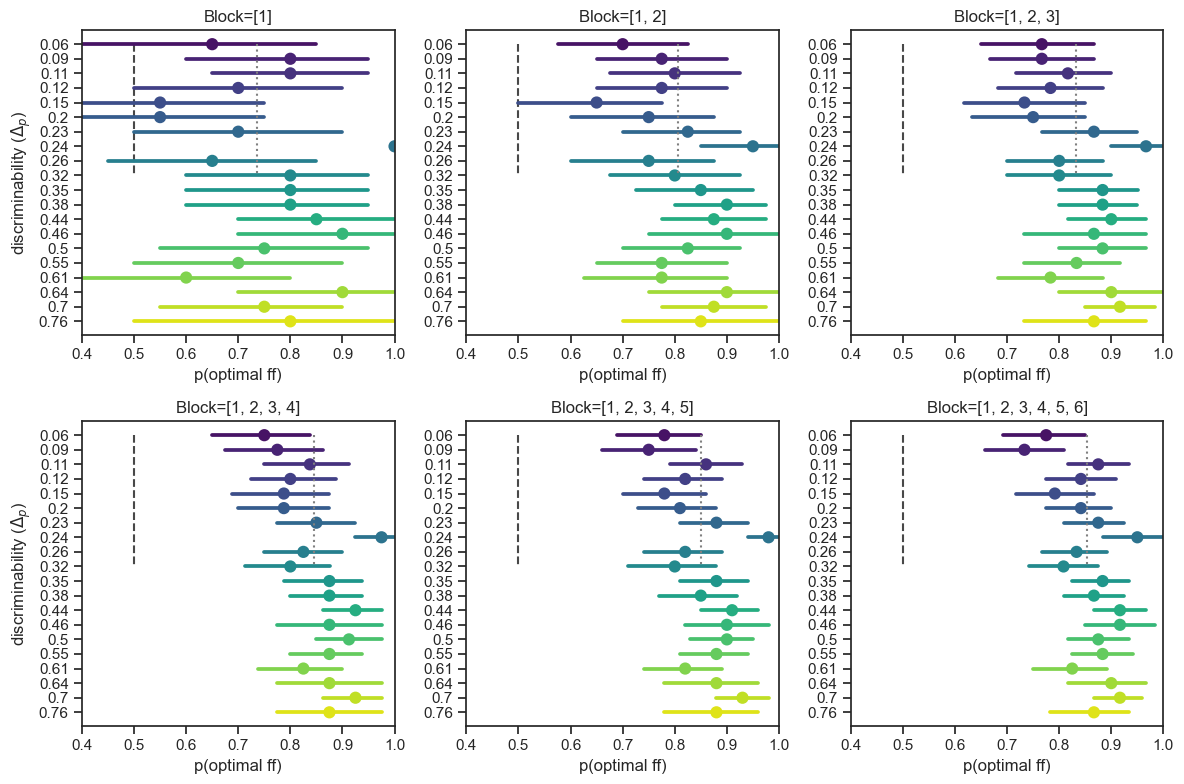

In [27]:

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 100})
blocklist=[]
for block in range(6):
    # blocklist = []
    blocklist.append(block)
    dff = df[df.session.isin(blocklist)]
    sns.set_style('ticks')
    plt.subplot(2, 3, block+1)
    ax = sns.pointplot(x='correct', y='uncertainty', data=dff, palette='viridis', errorbar='se',  zorder=-1, orient='h')
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
    plt.plot([0.5, 0.5], [0, 9], color='k', linestyle='--', zorder=-10, alpha=0.8)
    plt.plot([dff.correct.mean(), dff.correct.mean()], [0, 9], ':', color='grey')
    plt.xlim(0.4,1)
    if block in [0, 3]:
        plt.ylabel('discriminability ($\\Delta_p$)')
    # plt.ylabel('discriminability ($\\Delta_p$)')
    else:
        plt.ylabel('')
    plt.xlabel('p(optimal ff)')
    plt.title(f'Block={[i+1 for i in blocklist]}')
plt.tight_layout()
# import pingouin as pg
# df['correct'] = df['correct'].astype(int)
# pg.pairwise_tests(data=df, dv='correct', within='uncertainty', padjust='bonf', subject='prolificID')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,uncertainty,0.13,0.15,True,True,-5.038435,9.0,two-sided,0.000701,0.031557,bonf,54.963,-0.987860
1,uncertainty,0.13,0.23,True,True,-5.482870,9.0,two-sided,0.000389,0.017492,bonf,90.231,-1.253051
2,uncertainty,0.13,0.26,True,True,-6.946914,9.0,two-sided,0.000067,0.003018,bonf,401.631,-1.791393
3,uncertainty,0.13,0.33,True,True,-5.255661,9.0,two-sided,0.000524,0.023568,bonf,70.209,-1.258411
4,uncertainty,0.13,0.42,True,True,-8.374341,9.0,two-sided,0.000015,0.000690,bonf,1430.13,-2.219118
5,uncertainty,0.13,0.47,True,True,-8.464506,9.0,two-sided,0.000014,0.000633,bonf,1541.198,-1.957061
6,uncertainty,0.13,0.59,True,True,-7.054042,9.0,two-sided,0.000060,0.002682,bonf,444.443,-1.848183
7,uncertainty,0.13,0.68,True,True,-6.336170,9.0,two-sided,0.000135,0.006078,bonf,220.949,-1.838363
8,uncertainty,0.13,0.76,True,True,-5.051828,9.0,two-sided,0.000689,0.030988,bonf,55.807,-1.344799
9,uncertainty,0.15,0.23,True,True,-1.495352,9.0,two-sided,0.169036,1.000000,bonf,0.73,-0.335716


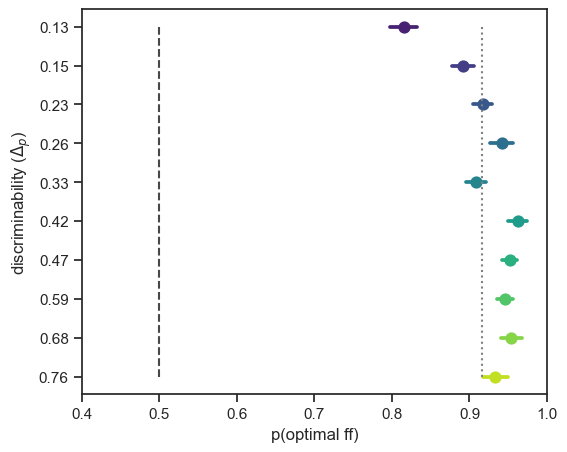

In [ ]:

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(6,5), 'figure.dpi': 100})
sns.set_style('ticks')
ax = sns.pointplot(x='correct', y='uncertainty', data=df, palette='viridis', errorbar='se', zorder=-1, orient='h')
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
plt.plot([0.5, 0.5], [0, 9], color='k', linestyle='--', zorder=-10, alpha=0.8)
plt.plot([df.correct.mean(), df.correct.mean()], [0, 9], ':', color='grey')
plt.xlim(0.4,1)
plt.ylabel('discriminability ($\\Delta_p$)')
plt.xlabel('p(optimal ff)')

import pingouin as pg
df['correct'] = df['correct'].astype(int)
pg.pairwise_tests(data=df, dv='correct', within='uncertainty', padjust='bonf', subject='prolificID')

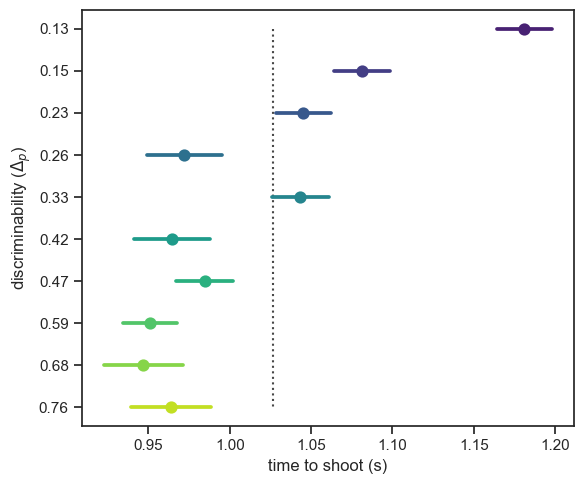

In [ ]:

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()

# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(6,5), 'figure.dpi': 100})
sns.set_style('ticks')
# palette = sns.color_palette('viridis')
ax = sns.pointplot(x='fireTime', y='uncertainty', data=df, palette='viridis',
                    errorbar='se', zorder=-1, orient='h')
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
plt.plot([df.fireTime.mean()]*2, [0, 9], color='k', linestyle=':', zorder=-10, alpha=0.8)
# plt.xlim(0.4,1)
plt.ylabel('discriminability ($\\Delta_p$)')
plt.xlabel('time to shoot (s)')

plt.tight_layout()
slides.add('test.pptx')
# pg.pairwise_ttests(data=df, dv='fireTime', within='uncertainty', subject='prolificID', padjust='bonf')

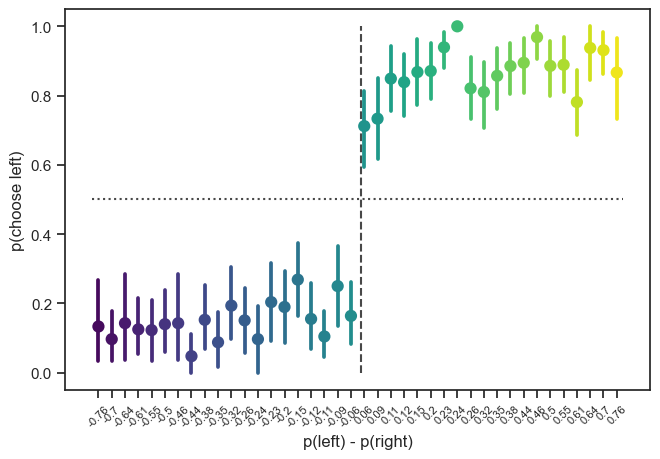

In [34]:
df['delta'] = (df.p1 - df.p2) * df.op1IsLeft + (df.p2 - df.p1) * (1 - df.op1IsLeft)
df['delta'] = df['delta'].round(2)
df['p(choose left)'] = (df.choice == 1) * df.op1IsLeft + (df.choice == 2) * (1 - df.op1IsLeft)

sns.set(rc={'figure.figsize':(7,5), 'figure.dpi': 100, 'font.size': 20})
sns.set_style('ticks')
sns.pointplot(x='delta', y='p(choose left)', data=df[df.session.isin(range(6))], palette='viridis', errorbar='se')
plt.xticks(rotation=45)
# plt.ylabel('P(optimal)')
plt.xlabel('p(left) - p(right)')
# get xlim
x0, x1 = plt.xlim()
plt.plot([x0, x1], [0.5, 0.5], color='k', linestyle=':', zorder=-10, alpha=0.8)
# plot a vertical line at 0
plt.plot([x1/2, x1/2], [0, 1], color='k', linestyle='--', zorder=-10, alpha=0.8)
plt.ylim(-0.05,1.05)

# reduce xtickslabels
plt.tick_params(axis='x', rotation=45, labelsize=8)
# rightpart leftmost option is optimal
# left part rightmost option is optimal
# plt.text(5, 0.2, 'right optimal', fontsize=12)
# plt.text(15, 0.2, 'left optimal', fontsize=12)
plt.tight_layout()
slides.add('bw.pptx')

In [ ]:
import numpy as np
pairs = [
    [0.12, 0.88], 
    [0.12, 0.71],
    [0.12, 0.45],
    [0.12, 0.22],
    [0.16, 0.84],
    [0.16, 0.63],
    [0.22, 0.37],
    [0.29, 0.88],
    [0.29, 0.71],
    [0.37, 0.84],
    [0.37, 0.63],
    [0.37, 0.45],
    [0.55, 0.88],
    [0.55, 0.63],
    [0.63, 0.78],
    [0.78, 0.88]
]

pairs = list(map(list, np.array([df.p1.values, df.p2.values]).T))
pairs = set(map(tuple, pairs))
# sort by delta
pairs = sorted(pairs, key=lambda x: abs(x[0] - x[1]))

# compute the distance between each pair
distances = []
for pair in pairs:
    d = (pair[0] - pair[1])
    distances.append(d)
    
np.unique(np.abs(distances))

array([0.13, 0.13, 0.15, 0.15, 0.23, 0.23, 0.26, 0.33, 0.33, 0.42, 0.47,
       0.59, 0.59, 0.68, 0.76])

In [ ]:
pairs

[(0.16, 0.29),
 (0.71, 0.84),
 (0.22, 0.37),
 (0.63, 0.78),
 (0.55, 0.78),
 (0.22, 0.45),
 (0.37, 0.63),
 (0.55, 0.88),
 (0.12, 0.45),
 (0.29, 0.71),
 (0.16, 0.63),
 (0.37, 0.84),
 (0.12, 0.71),
 (0.29, 0.88),
 (0.16, 0.84),
 (0.12, 0.88)]

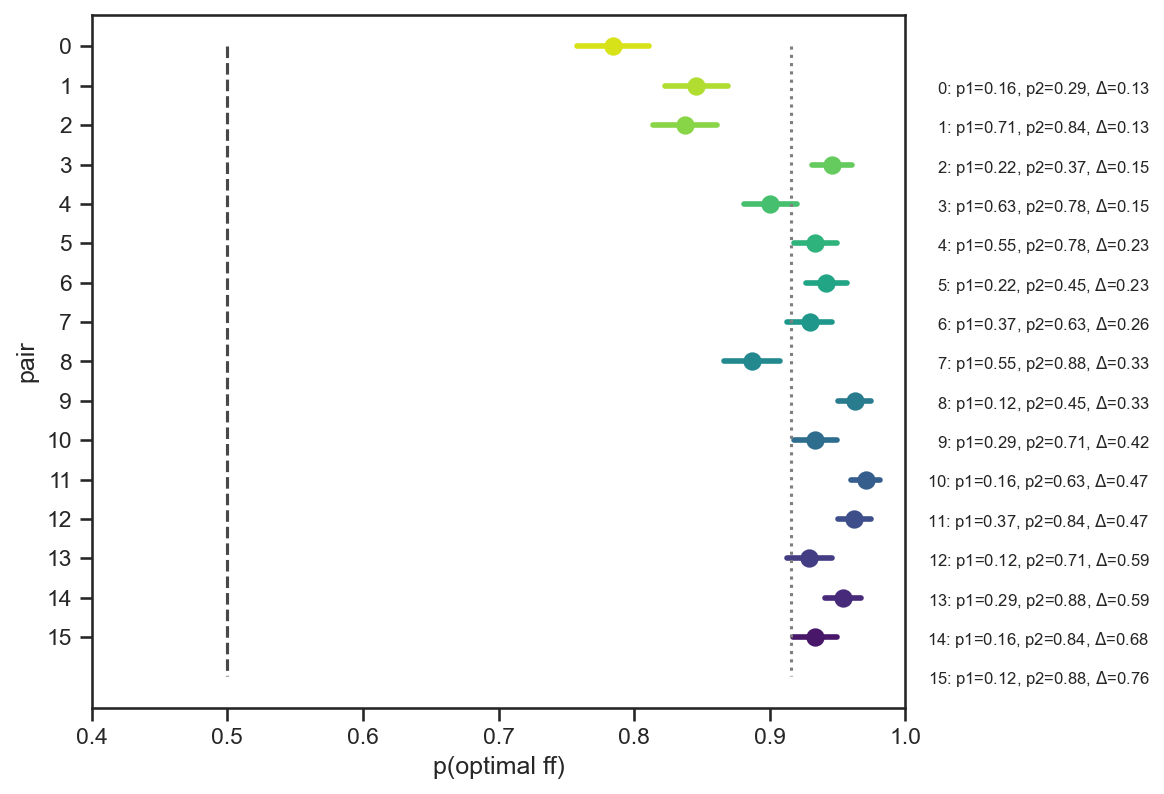

In [ ]:
df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(7,6), 'figure.dpi': 150})
palette = sns.color_palette('viridis', n_colors=len(pairs))[::-1]
sns.set_style('ticks')

sns.pointplot(x='correct', y='block', data=df, palette=palette,errorbar='se', zorder=-1, orient='h')
plt.plot([0.5, 0.5], [0, 16], color='k', linestyle='--', zorder=-10, alpha=0.8)
plt.xlim(0.4,1)

plt.ylabel('pair')
plt.xlabel('p(optimal ff)')

plt.plot([df.correct.mean(), df.correct.mean()], [0,16], ':', color='grey')

# for each ytick from 0 to 15, plot the value of pair at the corresponding ytick
for i, pair in enumerate(pairs):
    plt.text(1.18, 1.2+i, f'{i}: p1={pair[0]}, p2={pair[1]}, $\\Delta$={(np.abs(pair[0]-pair[1])).round(2)}', fontsize=8, ha='right')

# plt.tight_layout()
# plt.gca().invert_yaxis()

import pingouin as pg
df['correct'] = df['correct'].astype(int)
# print the whole table
# print(pg.pairwise_ttests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf'))
pg.pairwise_tests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf').to_csv('pairwise_tests.csv')



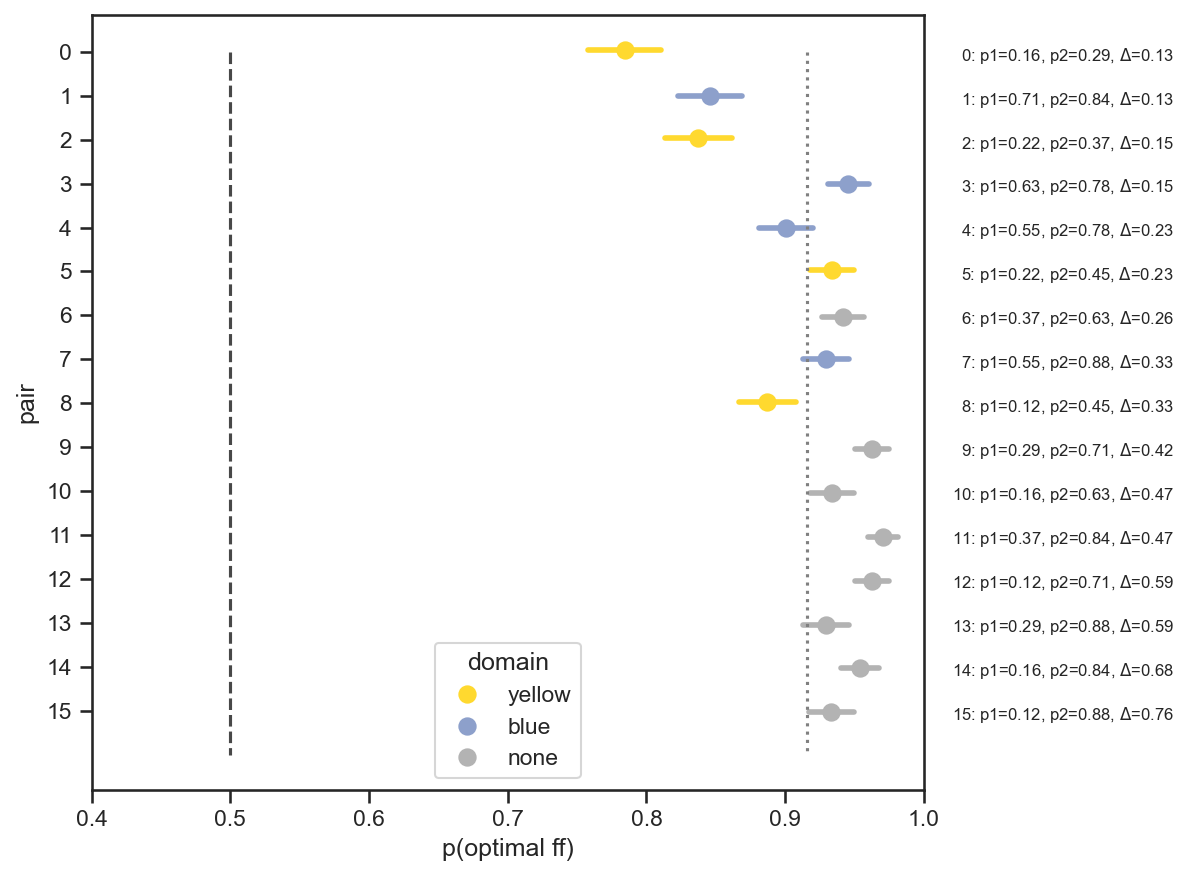

In [ ]:
df2 = df.copy()
# df2 = df2[df2.session.isin([0, 1, 2])]
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

def f(x):
    if x.p1 > 0.5 and x.p2 > 0.5:
        return 'blue'
    elif x.p1 < 0.5 and x.p2 <0.5:
        return 'yellow'
    else:
        return 'none'

df['domain'] = df.apply(f, axis=1)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(8,6), 'figure.dpi': 150})
palette = sns.color_palette('viridis', n_colors=len(pairs))[::-1]
sns.set_style('ticks')

#set Set2
sns.set_palette("Set2")

sns.pointplot(x='correct', y='block', hue='domain', data=df,errorbar='se', zorder=-1, orient='h', join=False, dodge=True, palette={'none': 'C7', 'blue':'C2', 'yellow':'C5'})
plt.plot([0.5, 0.5], [0, 16], color='k', linestyle='--', zorder=-10, alpha=0.8)
plt.xlim(0.4,1)

plt.ylabel('pair')
plt.xlabel('p(optimal ff)')

plt.plot([df.correct.mean(), df.correct.mean()], [0,16], ':', color='grey')

# for each ytick from 0 to 15, plot the value of pair at the corresponding ytick
for i, pair in enumerate(pairs):
    plt.text(1.18, .2+i, f'{i}: p1={pair[0]}, p2={pair[1]}, $\\Delta$={(np.abs(pair[0]-pair[1])).round(2)}', fontsize=8, ha='right')

plt.tight_layout()
slides.add('test.pptx')
# plt.gca().invert_yaxis()

import pingouin as pg
df['correct'] = df['correct'].astype(int)
# print the whole table
# print(pg.pairwise_ttests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf'))
pg.pairwise_tests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf').to_csv('pairwise_tests.csv')



In [ ]:
for pid in df.prolificID.unique():
    print(df[df.prolificID==pid].p1.values[0], df[df.prolificID==pid].p2.values[0], df[df.prolificID==pid].trial.values[0])

0.55 0.78 0
0.63 0.78 0
0.12 0.45 0
0.22 0.37 0
0.37 0.63 0
0.55 0.78 0
0.16 0.29 0
0.16 0.84 0
0.63 0.78 0
0.71 0.84 0


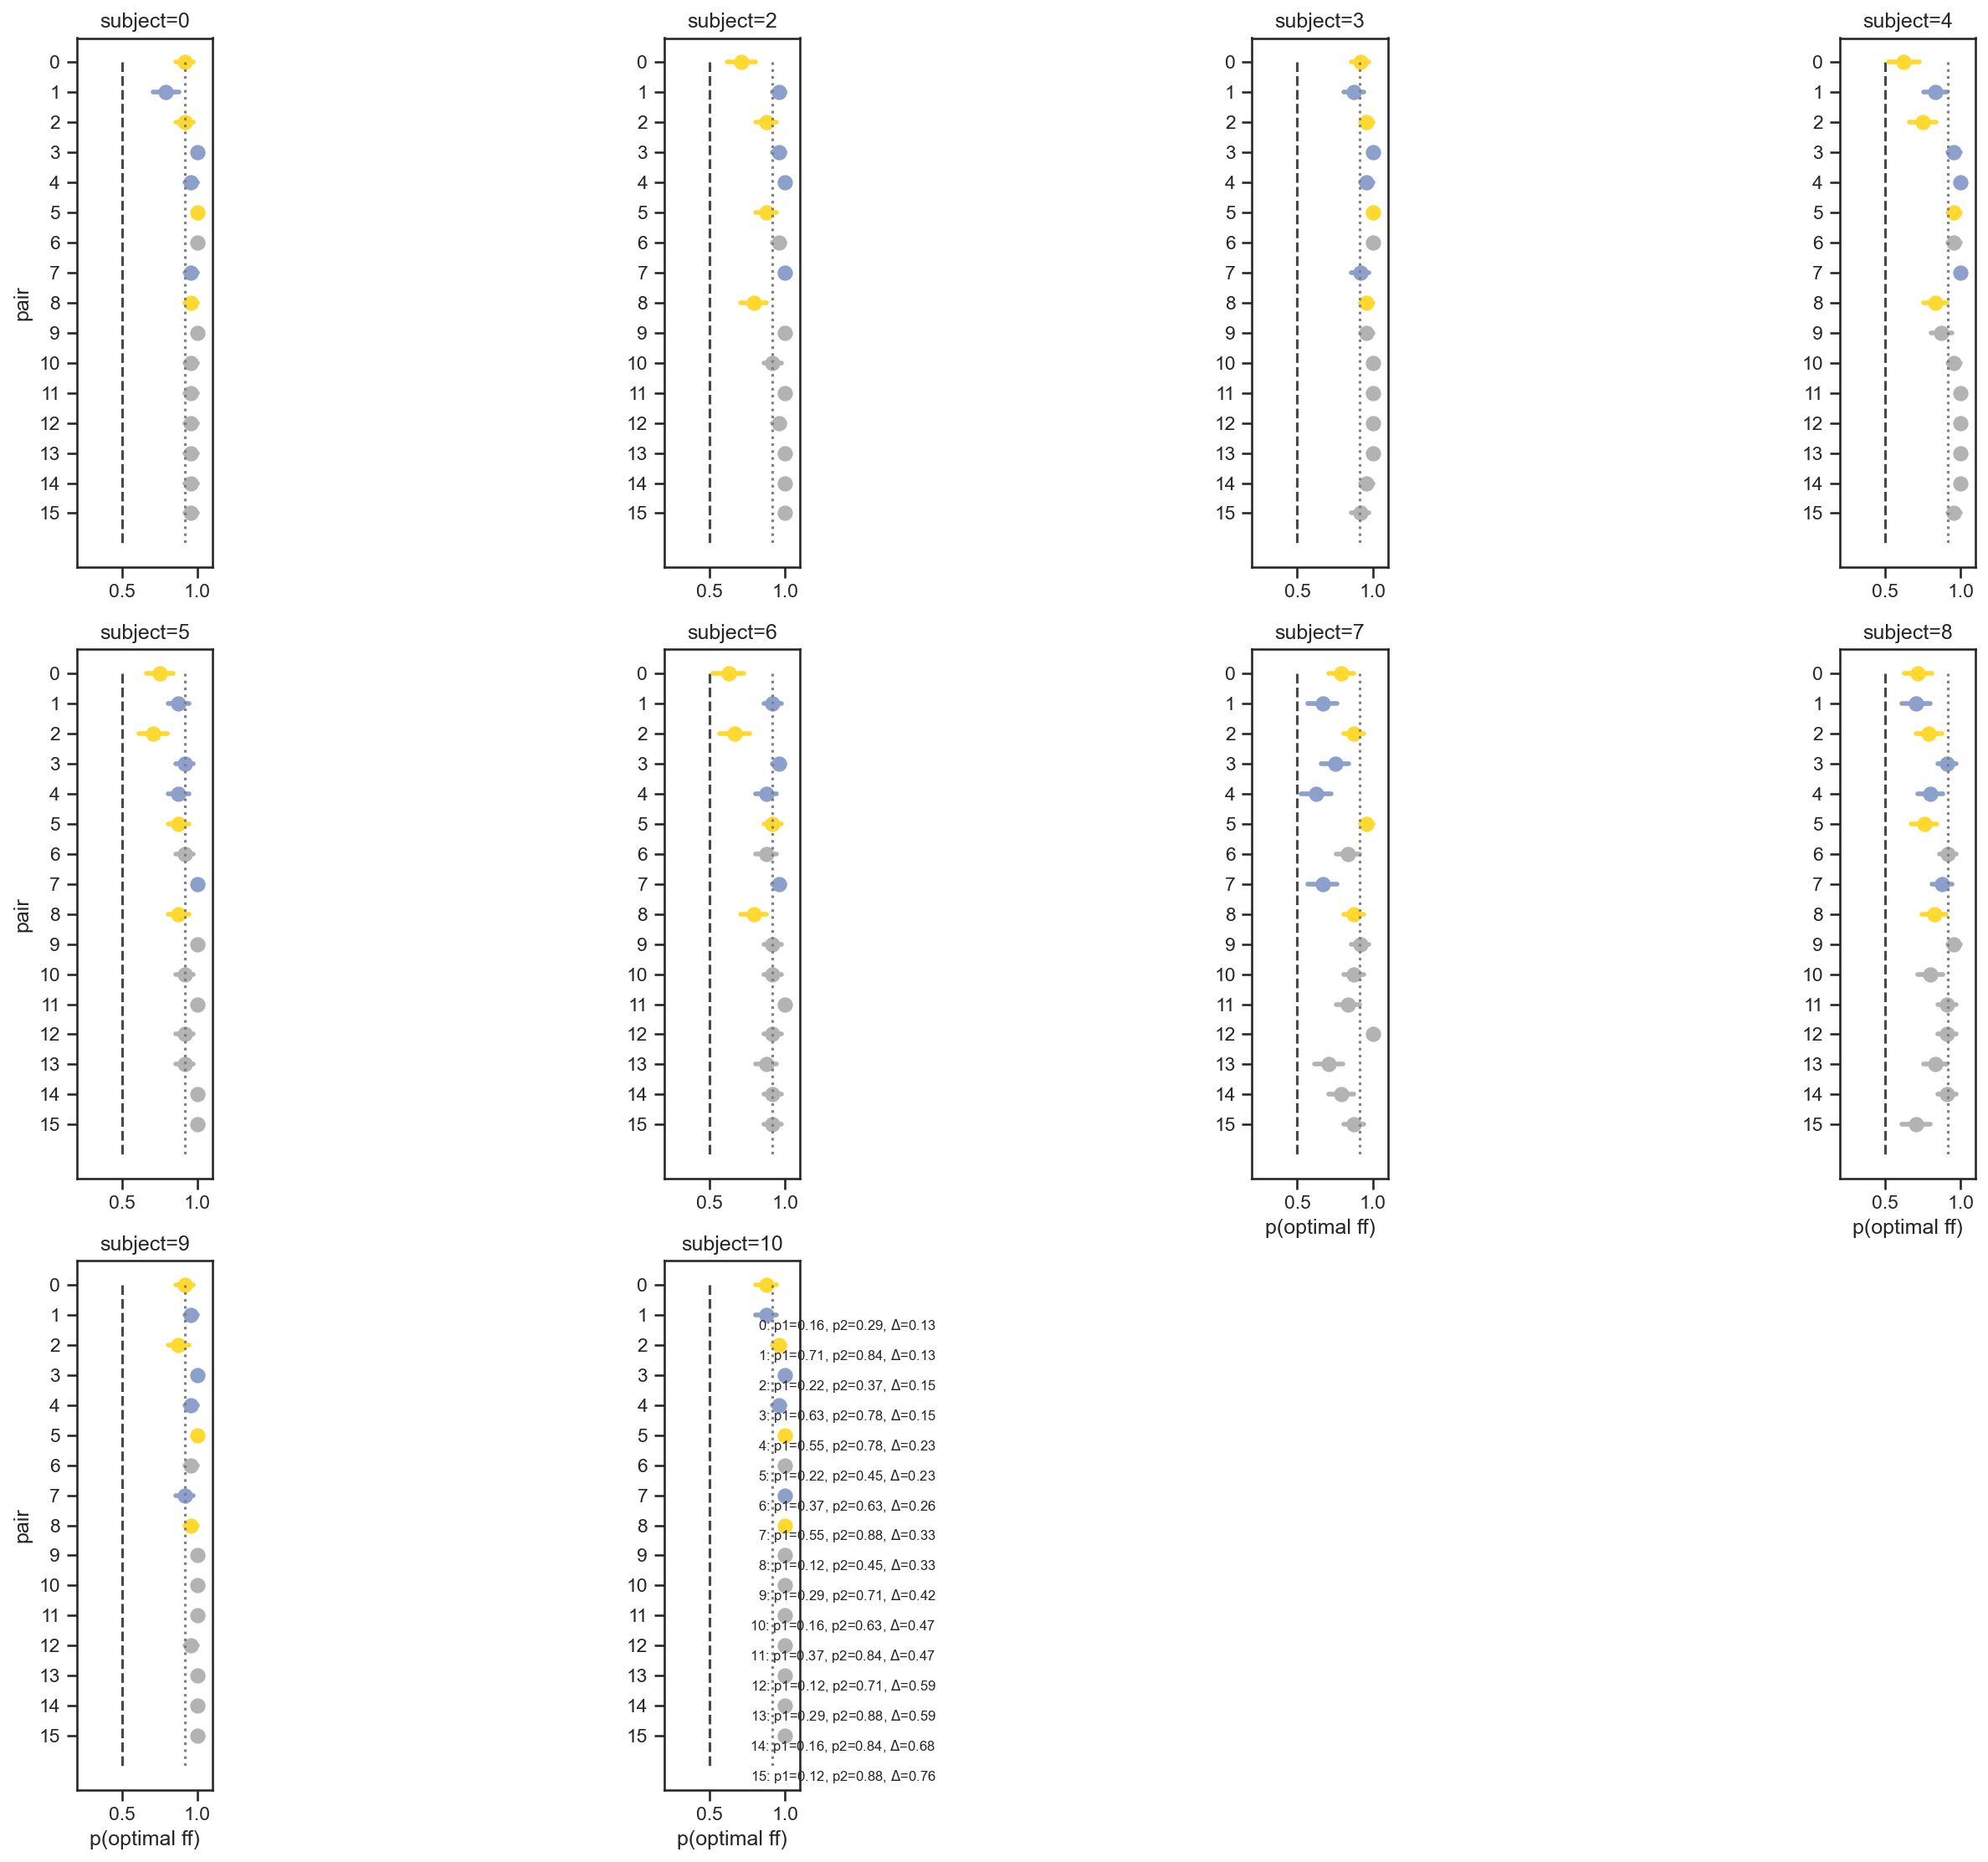

In [ ]:
df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
pairs = set(map(tuple, np.array([df.p1.values, df.p2.values]).T))
# order by delta
pairs = sorted(pairs, key=lambda x: abs(x[0] - x[1]))
def f(x):
    if x.p1 >  0.5 and x.p2 > 0.5:
        return 'blue'
    elif x.p1 < 0.5 and x.p2 < 0.5:
        return 'yellow'
    else:
        return 'none'

df['domain'] = df.apply(f, axis=1)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(16,15), 'figure.dpi': 150})
palette = sns.color_palette('viridis', n_colors=len(pairs))[::-1]
sns.set_style('ticks')
sns.set_palette("Set2")

for i, pid in enumerate(df.id.unique()):
    plt.subplot(3, 4, i+1)
    sns.set_palette("Set2")
    ax = sns.pointplot(x='correct', y='block', 
                       data=df[df.id==pid], join=False, hue='domain', 
                       palette={'none': 'C7', 'blue':'C2', 'yellow':'C5'},errorbar='se', 
                     zorder=-1, orient='h')
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
    plt.plot([0.5, 0.5], [0, 16], color='k', linestyle='--', zorder=-10, alpha=0.8)
    plt.xlim(0.2,1.1)

    plt.ylabel('')
    if i % 4 == 0 or i == 0:
        plt.ylabel('pair')
        
    plt.xlabel('')
    if i in [6, 7, 8, 9, 10, 11]:
        plt.xlabel('p(optimal ff)')
    plt.title(f'subject={pid}')
    plt.plot([df.correct.mean(), df.correct.mean()], [0,16], ':', color='grey')
    # legend off
    plt.legend([],[], frameon=False)
    plt.tight_layout()

# for each ytick from 0 to 15, plot the value of pair at the corresponding ytick
for i, pair in enumerate(pairs):
    plt.text(2, 1.5+i, f'{i}: p1={pair[0]}, p2={pair[1]}, $\\Delta$={(np.abs(pair[0]-pair[1])).round(2)}', fontsize=8, ha='right')

# plt.gca().invert_yaxis()
slides.add('test.pptx', )

import pingouin as pg
df['correct'] = df['correct'].astype(int)
# print the whole table
# print(pg.pairwise_ttests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf'))
pg.pairwise_tests(dv='correct', within='block', subject='prolificID', data=df, padjust='bonf').to_csv('pairwise.csv')



AttributeError: Line2D.set() got an unexpected keyword argument 'plot_kws'

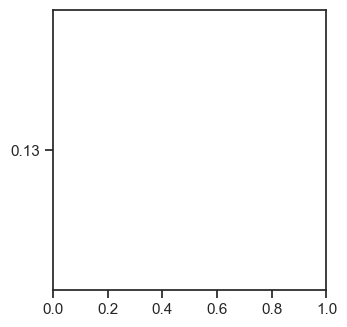

In [ ]:

df2 = df.copy()
df2['correct'] = (df2.p1 > df2.p2) & (df2.choice == 1) | (df2.p2 > df2.p1) & (df2.choice == 2)
df2['uncertainty'] = np.abs(df2.p1 - df2.p2).round(2)
df['uncertainty'] = np.abs(df.p1 - df.p2).round(2)
df['correct'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)

df2 = df2.filter(['uncertainty', 'correct', 'prolificID']).groupby(['uncertainty', 'prolificID'], as_index=False).mean()
# select only prolificID where correct > 0.6
# ids = means[means > 0.6].index

# df2 = df2[df2.prolificID.isin(ids)]


# sns.barplot(x='prolificID', y='correct', data=df2)
# sns.lineplot(x='t', y='correct', hue="prolificID", data=df2, color='black')
sns.set(rc={'figure.figsize':(12,8), 'figure.dpi': 100})
blocklist=[]
for block in range(6):
    # blocklist = []
    blocklist.append(block)
    dff = df[df.session.isin(blocklist)]
    sns.set_style('ticks')
    plt.subplot(2, 3, block+1)
    ax = sns.pointplot(x='correct', y='uncertainty', data=dff, palette='viridis', errorbar='se', plot_kws=dict(alpha=0.4), alpha=.4, zorder=-1, orient='h')
# plt.setp(ax.collections, alpha=.9) #for the markers
# plt.setp(ax.lines, alpha=.5)       #for the lines
# sns.stripplot(x='uncertainty', y='correct', data=df2, color='lightgray', alpha=0.9, edgecolor='w', zorder=1,lw=2)
    plt.plot([0.5, 0.5], [0, 9], color='k', linestyle='--', zorder=-10, alpha=0.8)
    plt.plot([dff.correct.mean(), dff.correct.mean()], [0, 9], ':', color='grey')
    plt.xlim(0.4,1)
    if block in [0, 3]:
        plt.ylabel('discriminability ($\\Delta_p$)')
    # plt.ylabel('discriminability ($\\Delta_p$)')
    else:
        plt.ylabel('')
    plt.xlabel('p(optimal ff)')
    plt.title(f'Block={[i+1 for i in blocklist]}')
plt.tight_layout()
# import pingouin as pg
# df['correct'] = df['correct'].astype(int)
# pg.pairwise_tests(data=df, dv='correct', within='uncertainty', padjust='bonf', subject='prolificID')